## Funcion Rastrigin

La **función de Rastrigin** es una de las funciones de prueba más utilizadas en **optimización** y **algoritmos bioinspirados**. Se emplea para evaluar el rendimiento de **algoritmos evolutivos, de enjambre o metaheurísticos**, porque es **no convexa, multimodal y difícil de optimizar**.

---

### 🔎 Definición matemática

En dimensión $n$, la función se define como:

$$
f(\mathbf{x}) = An + \sum_{i=1}^{n} \left[x_i^2 - A\cos(2\pi x_i)\right]
$$

donde:

* $\mathbf{x} = (x_1, x_2, ..., x_n)$ es un vector de variables,
* el parámetro habitual es $A = 10$,
* el **dominio típico** es $x_i \in [-5.12, 5.12]$.

### Propiedades principales

* **Óptimo global**:

  $$
  f(\mathbf{0}) = 0 \quad \text{en} \quad \mathbf{x} = (0, 0, ..., 0)
  $$
* **Multimodalidad**: presenta una gran cantidad de **mínimos locales**, distribuidos en un paisaje ondulado debido al término coseno.
* **Dificultad**: aunque el óptimo global es conocido y simple, llegar a él es complicado para muchos algoritmos porque pueden quedarse atrapados en mínimos locales.

---

### Usos

* Es un **benchmark estándar** en papers y estudios sobre optimización bioinspirada.
* Sirve para **probar la capacidad de exploración** y evitar la convergencia prematura de algoritmos evolutivos o de enjambre.
* Se incluye en casi todas las bibliotecas de funciones de prueba (junto con Sphere, Ackley, Rosenbrock, Griewank, etc.).

In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt

def rastrigin(x):
    """
        Calcula el valor de la función de Rastrigin en un punto.
    
        La función es multimodal y se usa como benchmark en optimización.
        El dominio típico es [-5.12, 5.12] para cada variable y el óptimo global
        se alcanza en x = 0 con f(x) = 0.
    
        Parámetros
        ----------
        x : list[float]
            Vector de variables.
    
        Retorna
        -------
        tuple[float]
            Valor de la función en x (tupla de un valor).
            Devuelve un valor muy grande si x está fuera del dominio.
    """

    A = 10
    
    for i in range(len(x)):
        if x[i] > 5.12 or x[i] < -5.12:
            return float(10**6),   # penalizamos salidas del dominio con fitness muy malo
            
    # Calculamos el sumatorio        
    total = sum([xi**2 - A * math.cos(2 * math.pi * xi) for xi in x])
    res = A*len(x) + total

    return (res,)

def plot_evolucion(logs, fill='iqr'):

    # Extraemos los datos de interes del logbook
    # IMPORTANTE -> Asegura arrays NumPy para operaciones vectorizadas y shes consistentes
    gens = np.asarray(logs[0].select('gen'))
    mins = np.vstack([np.asarray(log.select('min'), dtype=float) for log in logs])
    maxs = np.vstack([np.asarray(log.select('max'), dtype=float) for log in logs])
    avgs = np.vstack([np.asarray(log.select('avg'), dtype=float) for log in logs])

    mean_min = mins.mean(axis=0)
    mean_max = maxs.mean(axis=0)
    mean_avg = avgs.mean(axis=0)

    # Creamos la figura y eje para graficar
    fig, ax1 = plt.subplots()

    # Dibujamos las curvas:
    ax1.plot(gens, mean_min, 'b', label='Min')
    ax1.plot(gens, mean_max, 'r', label='Max')
    ax1.plot(gens, mean_avg, '--k', label='Avg')

    # Rellenamos el área entre min y max para dar una idea de la dispersión
    if fill == 'iqr':
        p25=np.percentile(avgs, 25, axis=0)
        p75=np.percentile(avgs, 75, axis=0)
        ax1.fill_between(gens, p25, p75, alpha=0.2, facecolor='g', label= 'Avg IQR (25-75%)')
    elif fill == 'minmax':
        gmin = avgs.min(axis=0)
        gmax = avgs.max(axis=0)
        ax1.fill_between(gens, gmin, gmax, alpha=0.2, facecolor='g', label='Avg min-max')

    # Etiquetas y formato
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness")
    # ax1.set_ylim([0, 20])
    ax1.legend(loc="upper right")     
    plt.grid(True)

    # Mostrar gráfico en pantalla
    plt.show()

In [2]:
# Importar librerias
import random
from deap import base, creator, tools, algorithms

# Definimos el problema
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Creación de la plantilla del individuo
creator.create('Individual', list, fitness=creator.FitnessMin)

# Intanciamos el objeto toolbox
toolbox = base.Toolbox()

# registramos una función para generar individuos aleatorios para mi población
toolbox.register('attr_uniform', random.uniform, -5.12, 5.12)

# registramos un metodo para generar individuos
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_uniform, 2)

# Registramos un metodo para generar poblaciones
toolbox.register('population', tools.initRepeat, list, toolbox.individual, 100)

# ======================================
# Registro de las operaciones genéticas
# ======================================

# Registro de la función de evaluación
toolbox.register('evaluate', rastrigin)

# Registro de la función de cruzamineto (crossover)
toolbox.register('mate', tools.cxSimulatedBinaryBounded, low=-5.12, up=5.12, eta=10)

# Registro del operador de mutación
toolbox.register('mutate', tools.mutPolynomialBounded, low=-5.12, up=5.12, eta=10, indpb=0.2)

# Registro de Selección
toolbox.register('select', tools.selTournament, tournsize=3)

mejor fitness: 0.001
mejor individuo: 0.009911623852300266
Mejor individuo global: [0.0010209653404757667, -0.006994658095780597] con fitness: 0.009911623852300266


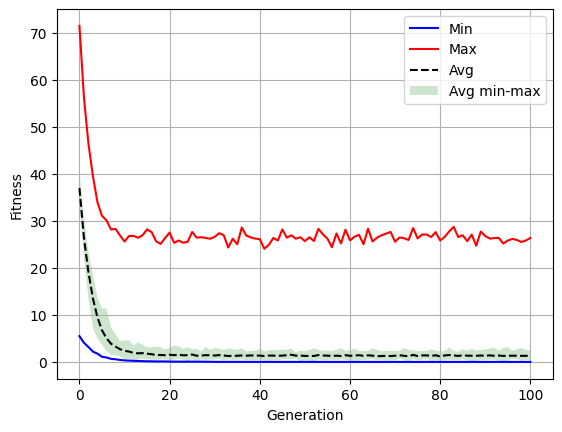

In [3]:
def main():
    CXPB, MUTPB, NGEN = 0.5, 0.3, 100

    # Creamos población inicial
    pop = toolbox.population()

    # Hall of Fame: mantiene los mejores individuos encontrados
    hof = tools.HallOfFame(1)
    
    # Definimos el objeto de estadísticas: qué métricas se registran por generación
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register('avg', np.mean)  # promedio del fitness en la población
    stats.register('std', np.std)   # desviación estándar del fitness
    stats.register('min', np.min)   # fitness mínimo
    stats.register('max', np.max)   # fitness máximo

    # Ejecutamos el algoritmo genético "simple" de DEAP:
    pop, logbook = algorithms.eaSimple(
        pop, toolbox,
        cxpb=CXPB,
        mutpb=MUTPB,
        ngen=NGEN,
        stats=stats,
        halloffame=hof,
        verbose=False
    )

    # Devolvemos el Hall of Fame (mejores individuos) y el logbook (histórico de stats)
    return hof, logbook

if __name__ == '__main__':

    random.seed(42)

    #Inicializamos la lista de soluciones
    list_best = []
    list_best_indv = []
    logs = []

    # Lanzamos el algoritmo n veces
    for i in range(50):
        best, log = main()
        logs.append(log)
        list_best.append(best[0].fitness.values[0])
        list_best_indv.append(best[0])

    # 'best' es un HallOfFame indexable; best[0] es el mejor individuo.
    # OJO: .fitness.values es una TUPLA; hay que indexar [0] si es fitness escalar.
    print(f"mejor fitness: {np.mean(list_best):.3f}")

    # El individuo es una lista de reales; imprimimos tal cual o con formato propio
    print(f"mejor individuo: {max(list_best)}")

    # Ahora puedo obtener el mejor entre todos
    best_global = max(list_best_indv, key=lambda ind: ind.fitness.values[0])  # si minimizas
    print("Mejor individuo global:", best_global, "con fitness:", best_global.fitness.values[0])

    # Dibujamos la evolución del fitness a lo largo de las generaciones
    plot_evolucion(logs, fill='minmax')


### Resultados obtenidos

Tras la ejecución del algoritmo genético sobre la función de Rastrigin en dos variables, se observa una **rápida convergencia inicial** durante las primeras generaciones, seguida de un proceso de refinamiento en el que el mejor individuo se aproxima progresivamente al óptimo global teórico.

El mejor resultado alcanzado corresponde al individuo $[0.0010, -0.0069]$ con un valor de la función $f(x,y) \approx 0.0099$, extremadamente cercano al mínimo global $f(0,0) = 0$. Asimismo, la evolución de la media poblacional indica que no solo un individuo aislado alcanza buenas soluciones, sino que la población en conjunto converge hacia regiones próximas al óptimo.

---

### Cambio en los operadores genéticos

En un inicio se utilizaron los operadores **`cxOnePoint`** (crossover de un punto) y **`mutGaussian`** (mutación gaussiana). Aunque funcionales, estos operadores presentan limitaciones al trabajar con **variables continuas**:

* El cruce por un punto está diseñado principalmente para cromosomas discretos, generando hijos poco consistentes en dominios reales.
* La mutación gaussiana puede producir valores fuera de los límites de definición de la función, lo que obligaba a penalizar con fitness elevados e introducía ruido en el proceso evolutivo.

---

### Operadores empleados en la versión final

Para solventar estas limitaciones se sustituyeron por operadores diseñados específicamente para variables reales:

* **Cruce Simulado Binario Acotado (`cxSimulatedBinaryBounded`)**
  Este operador genera descendientes que simulan el comportamiento de un cruce binario, pero en espacio continuo. Respeta siempre los límites del dominio $[-5.12, 5.12]$ y permite regular la cercanía de los hijos a sus padres mediante el parámetro `eta`.

* **Mutación Polinómica Acotada (`mutPolynomialBounded`)**
  Aplica cambios controlados en cada variable siguiendo una distribución polinómica, manteniendo siempre los valores dentro del dominio definido. El parámetro `eta` regula la magnitud de la mutación y `indpb` la probabilidad de que cada gen sea mutado.

El uso de estos operadores permitió **preservar la validez de los individuos**, reducir la necesidad de penalizaciones y mejorar el equilibrio entre exploración y explotación. Como resultado, el algoritmo logró soluciones muy próximas al óptimo global de manera consistente.